In [8]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'

In [7]:
import numpy as np
import pandas as pd
import os
import pydot
import graphviz

from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten, GRU, Concatenate, Dense, Dropout, Bidirectional, Attention, Input, Lambda, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize

In [9]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv")

In [10]:
columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
tourism_reviews_en = tourism_reviews_en[columns_to_use]

In [11]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   helpful_votes   5909 non-null   int64 
 1   location_id     5909 non-null   int64 
 2   review_id       5909 non-null   int64 
 3   review          5909 non-null   object
 4   review_subject  5909 non-null   object
 5   trip_type       5892 non-null   object
 6   rating          5909 non-null   int64 
 7   location_name   5909 non-null   object
 8   province        5909 non-null   object
 9   place_id        5909 non-null   object
 10  emotion         5909 non-null   object
 11  cleaned_review  5909 non-null   object
dtypes: int64(4), object(8)
memory usage: 554.1+ KB


In [7]:
tourism_reviews_en[['cleaned_review']].tail(1)

,cleaned_review
5908,fully recommend <OOV> <OOV> <OOV> genuine hist...


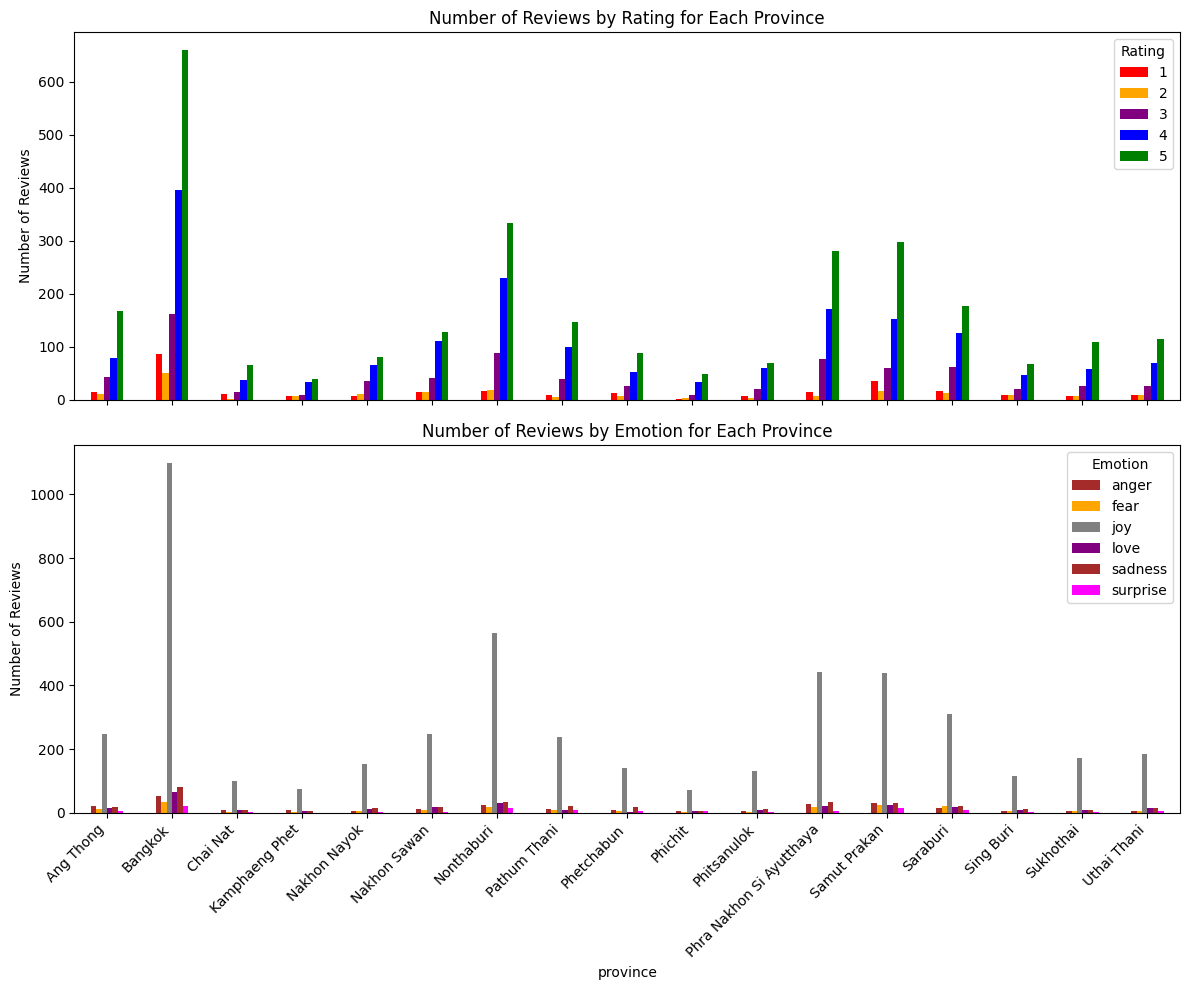

In [78]:

# จัดกลุ่มข้อมูลตาม province และ rating แล้วนับจำนวนรีวิว
rating_counts = tourism_reviews_en.groupby(['province', 'rating']).size().unstack(fill_value=0)

# จัดกลุ่มข้อมูลตาม province และ emotion แล้วนับจำนวนรีวิว
emotion_counts = tourism_reviews_en.groupby(['province', 'emotion']).size().unstack(fill_value=0)

# กำหนดสีสำหรับแต่ละ rating
rating_colors = {5: 'green', 4: 'blue', 3: 'purple', 2: 'orange', 1: 'red'}

# สร้าง palette ของสีสำหรับสุ่มสีของแต่ละ emotion
color_palette = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta']

# สุ่มสีสำหรับแต่ละ emotion และทำให้สีนี้สามารถทำซ้ำได้
np.random.seed(42)
emotion_colors = {emotion: np.random.choice(color_palette) for emotion in emotion_counts.columns}

# สร้าง subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# กราฟสำหรับ ratings
rating_counts.plot(kind='bar', stacked=False, color=[rating_colors[rating] for rating in sorted(rating_counts.columns)], ax=ax1)
ax1.set_title('Number of Reviews by Rating for Each Province')
ax1.set_ylabel('Number of Reviews')
ax1.legend(title='Rating')

# กราฟสำหรับ emotions
emotion_counts.plot(kind='bar', stacked=False, color=[emotion_colors[emotion] for emotion in emotion_counts.columns], ax=ax2)
ax2.set_title('Number of Reviews by Emotion for Each Province')
ax2.set_ylabel('Number of Reviews')
ax2.legend(title='Emotion')

# หมุนป้ายแกน x
plt.xticks(rotation=45, ha="right")

# ปรับ layout เพื่อไม่ให้กราฟซ้อนทับกัน
plt.tight_layout()

# แสดงกราฟ
plt.show()


In [12]:
import sys

utils_path = os.path.abspath(os.path.join(os.getcwd(), '../../utils'))
sys.path.append(utils_path)

from data_preparation import DataPreparation

dp = DataPreparation()

# Apply cleaning function to the 'review' column
tourism_reviews_en['cleaned_review'] = tourism_reviews_en['review'].apply(dp.clean_text)


In [12]:
max_len = 100

cleaned_reviews = tourism_reviews_en['cleaned_review'].values
location_ids = tourism_reviews_en['location_id'].values

# Initialize and fit the Tokenizer on the cleaned reviews
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # Use <OOV> for out-of-vocabulary words
tokenizer.fit_on_texts(cleaned_reviews)
word_index = tokenizer.word_index

# Initialize and fit the LabelEncoder on the location IDs
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(location_ids)

# Initialize and fit the CountVectorizer for n-grams
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000)
vectorizer.fit(cleaned_reviews)

CountVectorizer(max_features=10000, ngram_range=(1, 3))

In [13]:
tourism_reviews_en['trip_type'].unique()

array(['Family', 'Solo travel', 'Couples', 'NONE', 'Friends getaway',
       'Business', nan], dtype=object)

In [14]:
embedding_index = {}
with open(f'{FINE_TUNED_DIR}/glove/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100  # Based on GloVe model used (50, 100, 200, 300)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
def preprocess_text(cleaned_review):
    # Tokenize and pad the sequences
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    
    # Generate n-gram features
    ngram_features = vectorizer.transform([cleaned_review]).toarray()
    
    return padded_sequence[0], ngram_features[0]  # Flatten ngram_features to remove the extra dimension


In [43]:
input_text = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(input_text)

gru_output = GRU(128, return_sequences=True)(embedding_layer)
attention_output = Attention()([gru_output, gru_output])
attention_output = Flatten()(attention_output)

input_ngrams = Input(shape=(10000,))
ngram_dense = Dense(128, activation='relu')(input_ngrams)

combined = Concatenate()([attention_output, ngram_dense])

dense_1 = Dense(128, activation='relu')(combined)
dropout_1 = Dropout(0.5)(dense_1)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dropout_1)

# Define the model
GRU_model = Model(inputs=[input_text, input_ngrams], outputs=output_layer)

/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [44]:
GRU_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [37]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_reviews, y, test_size=0.2, random_state=42)

# Preprocess the text data
X_train_text = np.array([preprocess_text(text)[0] for text in X_train])
X_test_text = np.array([preprocess_text(text)[0] for text in X_test])
X_train_ngrams = np.array([preprocess_text(text)[1] for text in X_train])
X_test_ngrams = np.array([preprocess_text(text)[1] for text in X_test])



In [52]:
# Train the model
history = GRU_model.fit([X_train_text, X_train_ngrams], y_train, epochs=10, batch_size=32, validation_data=([X_test_text, X_test_ngrams], y_test))


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 4.9060e-04 - loss: 7.2912 - val_accuracy: 0.0017 - val_loss: 7.2492
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0054 - loss: 7.0639 - val_accuracy: 0.0000e+00 - val_loss: 7.1774
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0184 - loss: 6.4533 - val_accuracy: 0.0042 - val_loss: 7.1201
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.0903 - loss: 5.4382 - val_accuracy: 0.0051 - val_loss: 7.1489
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2191 - loss: 4.1450 - val_accuracy: 0.0110 - val_loss: 7.4976
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.4155 - loss: 2.8692 - val_accuracy: 0.0169 - val_loss: 7.6477
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5633 - loss: 1.9998 - val_accuracy: 0.0118 - val_loss: 8.2096
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6833 - loss: 1.3948 - 

In [1]:
from tensorflow.keras.models import load_model
# Save the trained model
# GRU_model.save(f'../../models/GRU_model_sample.h5')
GRU_model = load_model(f'../../models/GRU_model_sample.h5')


In [73]:
def predict_location(cleaned_review):
    # Preprocess the input review text
    padded_sequence, ngram_features = preprocess_text(cleaned_review)
    
    # Ensure both padded_sequence and ngram_features have the correct shape
    padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Shape becomes (1, max_len)
    ngram_features = np.expand_dims(ngram_features, axis=0)  # Shape becomes (1, 10000)
    
    # Predict the location ID using both inputs
    predicted_class = GRU_model.predict([padded_sequence, ngram_features])
    predicted_label = np.argmax(predicted_class, axis=-1)

    # Convert the predicted label back to the location ID or name
    predicted_location = label_encoder.inverse_transform(predicted_label)
    
    return predicted_location

In [82]:
# Example usage
sample_review = "Museum"
predicted_location = predict_location(sample_review)
# print(f"Predicted location: {predicted_location}")
filtered_df = tourism_reviews_en[tourism_reviews_en['location_id'].isin(predicted_location)]

unique_location_df = filtered_df.drop_duplicates(subset='location_id')
unique_location_df[['province', 'location_name']]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,province,location_name
997,Pathum Thani,Chao Mae Song Nang Phi Nong Shrine


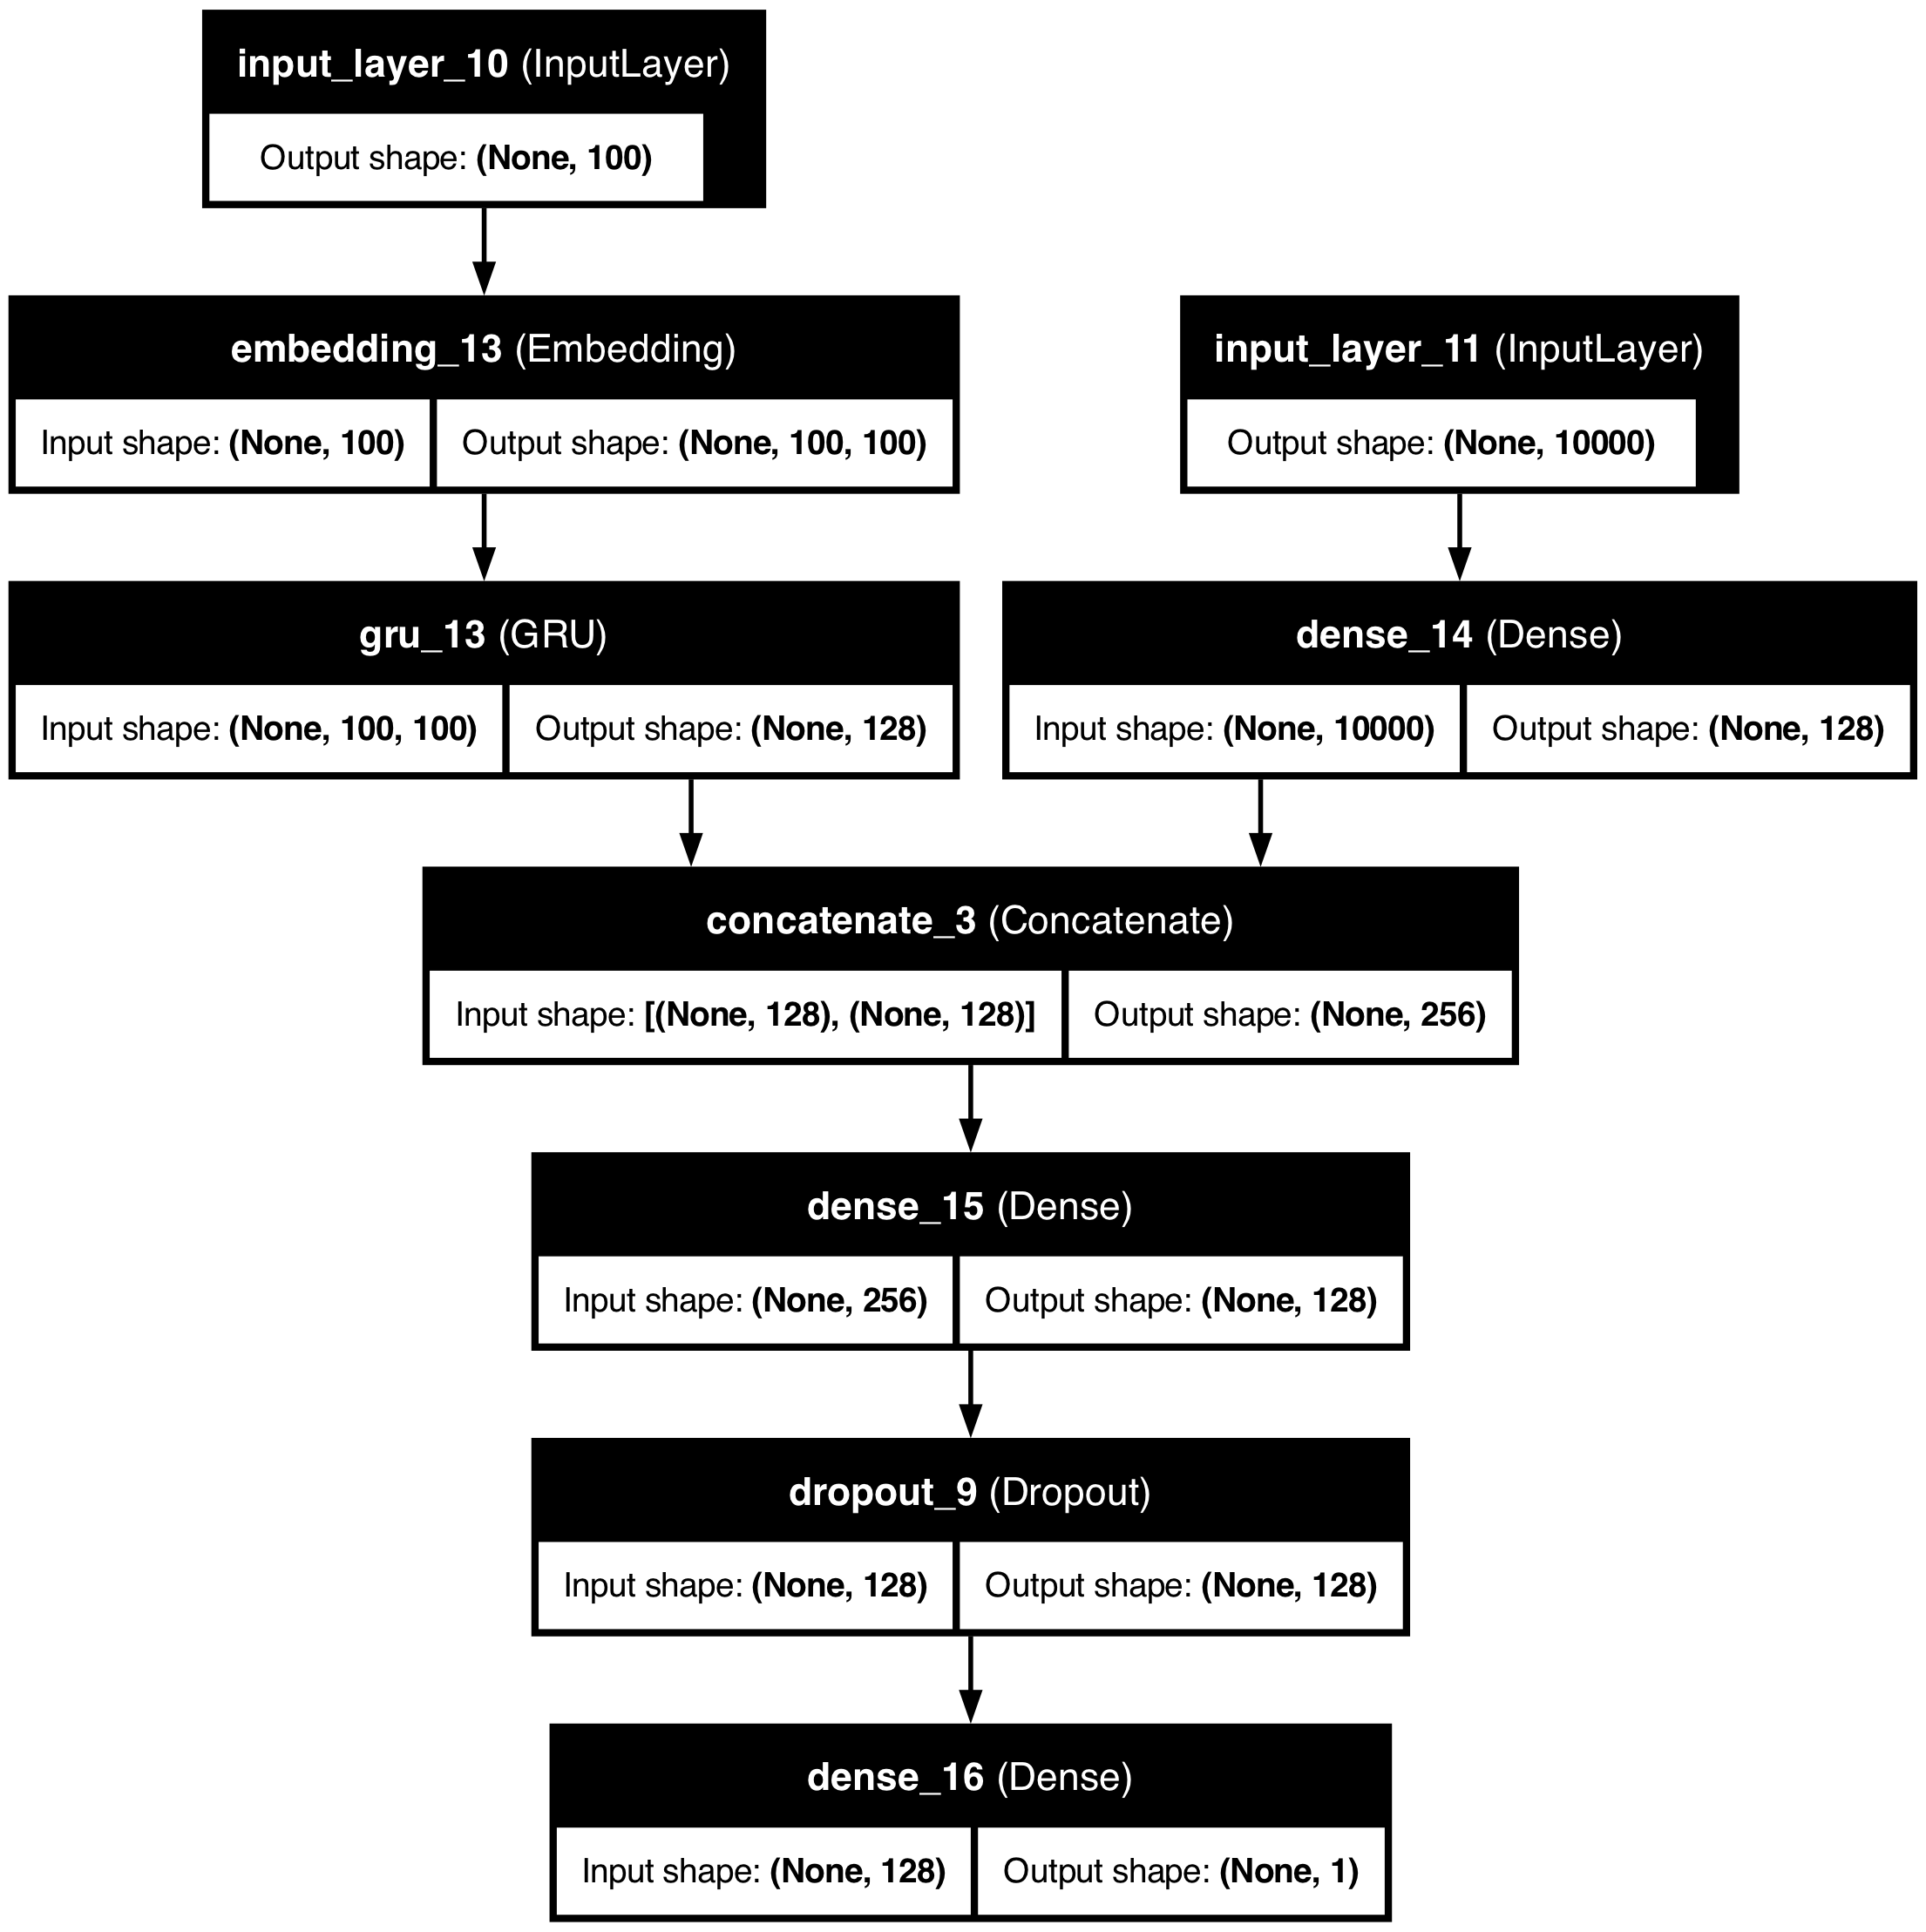

In [2]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(GRU_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [3]:
# Display model summary
GRU_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 100, 100)  │  1,710,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ (None, 128)       │     88,320 │ embedding_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │  1,280,128 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ gru_13[0][0],     │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │        129 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,111,475 (11.87 MB)

 Trainable params: 1,401,473 (5.35 MB)

 Non-trainable params: 1,710,000 (6.52 MB)

 Optimizer params: 2 (12.00 B)

In [41]:
# Check class distribution in y_test
print("Class distribution in y_test:")
print(np.bincount(y_test))

Class distribution in y_test:
[0 2 2 ... 2 0 1]


In [ ]:
print("First 10 predicted probabilities:")
print(y_pred[:10])

print("First 10 predicted classes:")
print(y_pred_classes[:10])

print("First 10 true classes:")
print(y_test[:10])


In [45]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format if needed
class_weights = dict(enumerate(class_weights))

# Re-train the model with class weights
GRU_model.fit([X_train_text, X_train_ngrams], y_train, epochs=10, batch_size=32, class_weight=class_weights, validation_data=([X_test_text, X_test_ngrams], y_test))


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.0011 - loss: 8.8085 - val_accuracy: 0.0000e+00 - val_loss: 7.2564
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.0031 - loss: 8.5342 - val_accuracy: 0.0025 - val_loss: 7.2381
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0158 - loss: 7.9387 - val_accuracy: 0.0042 - val_loss: 7.2096
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.0632 - loss: 6.4524 - val_accuracy: 0.0059 - val_loss: 7.1434
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1516 - loss: 5.2022 - val_accuracy: 0.0068 - val_loss: 7.4521
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.2672 - loss: 3.7727 - val_accuracy: 0.0118 - val_loss: 7.7159
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.3964 - loss: 2.8231 - val_accuracy: 0.0085 - val_loss: 7.9833
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5231 - loss: 2.1179 - val_

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


KeyboardInterrupt: 